### Transformers for NLP 

### Classification (e.g. binary, multilabel, multiclass)

Как вы уже знаете задача классификации - одна из важных задач в ML, в том числе при работе с текстом и последовательностями. В NLP она применяется для решения многих проблем, например, проставление тегов для отзывов клиентов, классификация языков, семантическая классификация, поиск именованных сущностей и т.д. Мы посмотрим на решение задачи классификации в разрезе определения семантики (эмоциональной окраски) сообщений в социальной сети Twitter.

Для целей иллюстрации использования архитектуры Transformer, в данной задаче мы будем использовать архитектуру, разработанную гуглом, которая называется - BERT, а точнее, уменьшенный вариант данного трансформера - DistillBERT. Подробнее про архитектуру можно прочитать [тут](https://arxiv.org/pdf/1910.01108.pdf) и углубиться в математическую составляющую данного алгоритма.

Так как мы будем использовать довольно мощную библиотеку от hugging face, стоит упомянуть, что она поставляется с нексолькими отдельными модулями для полноценной работы с трансформерами:
1. Datasets - как понятно из названия, модуль для работы с датасетами и с данными
2. Transformers - модуль, через который мы можем скачивать чекпойнты модели и архитектуру, чтобы сэкономить время на обучении и построении архитектуры
3. Tokenizers
4. Metrics
5. Accelerate - модуль, который содержит техники ускорения модели (квантизация, параллелизация и прочие полезности)


Для решения текущей задачи наш пайплайн будет выглядить следующим образом Datasets -> Tokenizers -> Transofrmers -> Datasets

### Datasets

In [1]:
# list_datasets() -> function to see what datasets are available on the Hugging Face Hub 
# OLD approach:
# from datasets import list_datasets 

from huggingface_hub import list_datasets

all_datasets = list(list_datasets())
print("The Hub contains {} different datasets.".format(len(all_datasets)))
print("The first 5: ", all_datasets[:5])

The Hub contains 58471 different datasets.
The first 5:  [DatasetInfo: { 
  {'_id': '621ffdd236468d709f181d58',
   'author': None,
   'cardData': None,
   'citation': '@inproceedings{veyseh-et-al-2020-what,\n'
               '   title={{What Does This Acronym Mean? Introducing a New Dataset for Acronym Identification and '
               'Disambiguation}},\n'
               '   author={Amir Pouran Ben Veyseh and Franck Dernoncourt and Quan Hung Tran and Thien Huu Nguyen},\n'
               '   year={2020},\n'
               '   booktitle={Proceedings of COLING},\n'
               '   link={https://arxiv.org/pdf/2010.14678v1.pdf}\n'
               '}',
   'description': 'Acronym identification training and development sets for the acronym identification task at '
                  'SDU@AAAI-21.',
   'disabled': False,
   'downloads': 4565,
   'gated': False,
   'id': 'acronym_identification',
   'lastModified': '2023-01-25T14:18:28.000Z',
   'likes': 17,
   'paperswithcode_id': 'acronym

Соответственно нам вернулись метаданные по датасетам, где у каждого датасета, существует название, описание и прочие полезные вещи. Все находится в json подобном объекте. Нам необходим датасет emotion

Обычный пайплайн для работы с датасетом и моделью:

<img src="./../src/imgs/pipeline_transformers.png">

In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion") # the input is the string that represents a dataset's name. Where to find dataset's name -> documentation https://huggingface.co/docs/datasets/index

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
# DatasetDict is an object which is similar to Python's dict so we can access an individual split 
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
# access a single observation by its index
# single row is represented as a dictionary, where keys correspond to the column names
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
# access the column names
train_ds.column_names

['text', 'label']

Off Top: Datasets объект основан на [Apache Arrow](https://arrow.apache.org/), технологии, которая определяет типизированный колоночный (столбцовый) формат хранения данных, эффективный с точки зрения памяти, чем родные методы Python. Таким образом, мы можем посмотреть типы данных, используемые под капотом, обратившись к аттрибуту features для нашего объекта Dataset:

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


Во многих случаях вам все равно придется работать со своими собственными данными, которые находятся либо локально у вас, либо на серверах компании. Модуль `datasets` предоставляет несколько вариантов работы с локальными и удаленными наборами данных. Например:
* csv: `load_dataset("csv", data_files="path_to_file.csv"`
* text: `load_dataset("text", data_files="path_to_text_file.csv"`
* json: `load_dataset("json", data_files="path_to_json_file.csv`

### Dataset's EDA


Класс __Datasets__ предоставляет множество низкоуровневых методов для нарезки данных, для обработки данных и применение функций. Часто бывает удобно преобразовать объект Dataset в Pandas DataFrame, чтобы получить доступ к высокоуровневым API например для визуализации и анализа данных. Для обеспечения такого преобразования используется метод set_format(), который позволяет нам изменять формат вывода объекта Dataset. Обратите внимание, что при этом не изменяется основной формат данных (который представляет собой таблицу Arrow), и при необходимости можно перейти к другому формату позже:

[Документация](https://huggingface.co/docs/datasets/use_dataset)

In [9]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


метки представлены в виде целых чисел, поэтому воспользуемся методом int2str() для создания нового столбца в нашем DataFrame с соответствующими именами меток. Имейте в виду что метод int2str является bound методом. [Подробнее о bound methods/functions](https://stackoverflow.com/questions/13130574/what-does-bound-method-error-mean-when-i-call-a-function)

In [10]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


При решении задач классификации текстов целесообразно изучить распределение примеров по классам. Набор данных со скошенным распределением классов может потребовать иного подхода при обучении и при выборе метрик оценки качества, чем сбалансированное распределение классов.

[Документация по работе с библиотекой imbalanced-learn scikit-learn](https://imbalanced-learn.org/stable/)

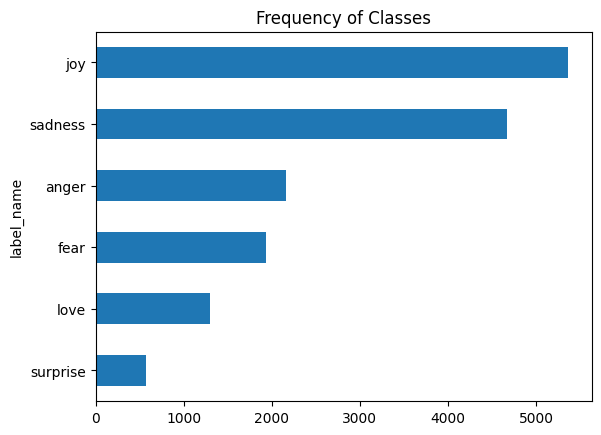

In [11]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Модели трансформеров имеют максимальную длину входной последовательности (длина контекста). Для приложений, использующих DistilBERT, максимальный размер контекста составляет 512 токенов, то есть несколько абзацев текста. Токен - это атомарный фрагмент текста (одно уникальное слово). Мы можем получить приблизительную оценку длины контекста в датасете, посмотрев на распределение слов в твите:

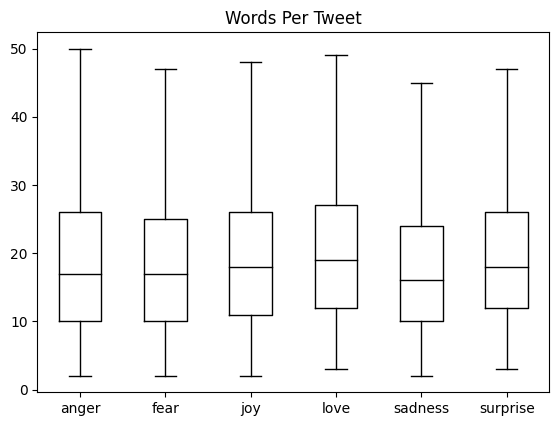

In [12]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
emotions.reset_format()

### Tokenization

Простейшая схема токенизации заключается в подаче в модель каждого символа по отдельности. В Python объекты str на самом деле являются массивами, что позволяет нам быстро реализовать токенизацию на уровне символов с помощью всего одной строки кода:

In [14]:
# Character level
text = "Tokenization is our first goal in NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n', ' ', 'i', 's', ' ', 'o', 'u', 'r', ' ', 'f', 'i', 'r', 's', 't', ' ', 'g', 'o', 'a', 'l', ' ', 'i', 'n', ' ', 'N', 'L', 'P', '.']


каждый символ должен быть преобразован в целое число, что иногда называют нумерацией. Один из простых способов сделать это - закодировать каждую уникальную лексему или стемму (в данном случае это символы) уникальным целым числом:

In [15]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'l': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'u': 18, 'z': 19}


Таким образом, мы получаем отображение каждого символа в нашем словаре на уникальное целое число. Теперь мы можем использовать token2idx для преобразования лексического текста в список целых чисел:

In [16]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 11, 7, 13, 10, 19, 6, 17, 10, 14, 13, 0, 10, 16, 0, 14, 18, 15, 0, 8, 10, 15, 16, 17, 0, 9, 14, 6, 12, 0, 10, 13, 0, 3, 2, 4, 1]


Вместо того чтобы разбивать текст на символы, мы можем разбить его на слова и сопоставить каждое слово целому числу. 

Использование слов с самого начала позволяет модели **пропустить этап обучения слов из символов и тем самым снизить сложность процесса обучения.**

Один из простых классов токенизаторов слов использует пробельные символы для токенизации текста. Мы можем сделать это, применив функцию Python `split()` непосредственно к исходному тексту:

In [17]:
# Word tokenization
tokenized_text = text.split()
print(tokenized_text)

['Tokenization', 'is', 'our', 'first', 'goal', 'in', 'NLP.']


Далее мы можем выполнить те же действия, что и для символьного токенизатора, чтобы сопоставить каждое слово с идентификатором. Однако уже сейчас видна одна потенциальная проблема, связанная с этой схемой токенизации: пунктуация не учитывается, поэтому токен NLP. рассматривается как один токен. Учитывая, что слова могут иметь склонения, спряжения или неправильное написание, размер словарного запаса может легко вырасти до миллионов...

Наличие большого словарного корпуса уже является проблемой, поскольку требует от нейронных сетей огромного количества параметров. 

Например, у нас есть 1 млн. уникальных слов и мы хотим сжать входные векторы размером в 1 млн. до 1 тыс. векторов в первом слое нашей нейронной сети. Это стандартный шаг в большинстве архитектур, и результирующая матрица весов этого первого слоя будет содержать 1 млн. весовых коэффициентов, что проблема, так как получается, что 1 тыс. = 1 млрд. весов. Это уже сопоставимо с самой большой моделью GPT-2 (~152 bn parameters).

Мы хотим избежать такого расточительного отношения к параметрам модели, поскольку обучение моделей обходится дорого, а большие модели сложнее поддерживать. Общий подход заключается в том, чтобы ограничить словарный запас и отбросить редкие слова, рассматривая, скажем, 100 000 наиболее часто встречающихся слов в корпусе. Слова, не входящие в словарный запас, классифицируются как "неизвестные" и сопоставляются с общим маркером `UNK`. Это означает, что в процессе токенизации слов мы теряем потенциально важную информацию, поскольку модель не имеет сведений о словах, связанных с `UNK`.

<br>

### Токенизация по подсловам (н-грам токенизация)

Основная идея токенизации подслов (n-gram tokenization) заключается в том, чтобы объединить лучшие аспекты токенизации символов и слов. С одной стороны, мы хотим разбить редкие слова на более мелкие единицы, чтобы модель могла работать со сложными словами и опечатками. С другой стороны, мы хотим сохранить часто встречающиеся слова как уникальные сущности, чтобы длина входных данных была приемлемой. Главной отличительной особенностью токенизации подслов (как и токенизации слов) является то, что она обучается на основе корпуса предварительно обученного с помощью набора статистических правил и алгоритмов.

У нас уже есть доступ к таким предобученным токенизаторам и поэтому мы можем легко воспользоваться ими обратившись к `AutoTokenizer` и указав название модели:

In [18]:
# N-gram tokenization
# WordPiece Algorithm ->
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [19]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [20]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 3989, 2003, 2256, 2034, 3125, 1999, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
# Zero Shot learning

# reverse encoding
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [22]:
print(tokens)

['[CLS]', 'token', '##ization', 'is', 'our', 'first', 'goal', 'in', 'nl', '##p', '.', '[SEP]']


In [23]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenization is our first goal in nlp. [SEP]


In [24]:
tokenizer.vocab_size

30522

In [25]:
tokenizer.model_max_length

512

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Токенизация всего нашего датасета:

In [27]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [28]:
# for zeros -> [PAD] [CLS] [SEP], [MASK], [UNK]
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

In [30]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Файнтюнинг модели для нашей задачи

<img src="./../src/imgs/transformer_family.png">

In [31]:
# Feature Extraction
# Fine Tuning 
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [32]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") # FYI: test always!
print("Tensor: ", inputs['input_ids'].size(), type(inputs['input_ids']))

Tensor:  torch.Size([1, 6]) <class 'torch.Tensor'>


In [33]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [34]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [35]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [36]:
def extract_hidden_states(batch):
    inputs =  {k:v.to(device) for k,v in batch.items()
               if k in tokenizer.model_input_names}
    # extraction of last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [37]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [38]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

In [39]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [40]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [41]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)


0.6335

In [42]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [43]:
# Transformer Finetuning 
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [45]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"


training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [46]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

D:\hw\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [47]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

In [48]:
preds_output.metrics

{'test_loss': 0.14409282803535461,
 'test_accuracy': 0.936,
 'test_f1': 0.9362254341811181,
 'test_runtime': 1.944,
 'test_samples_per_second': 1028.807,
 'test_steps_per_second': 16.461}

In [49]:
y_preds = np.argmax(preds_output.predictions, axis=1)

Анализ ошибок

Прежде чем двигаться дальше, следует исследовать предсказания нашей модели. Простой, но мощный прием - сортировка валидационных выборок по потерям модели. Когда мы передаем метку во время прямого прохода, потери автоматически вычисляются и возвращаются. функция, которая возвращает потери вместе с предсказанной меткой:

In [51]:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [52]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [53]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [54]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.274113
882,i feel badly about reneging on my commitment t...,love,sadness,6.957222
318,i felt ashamed of these feelings and was scare...,fear,sadness,6.262174
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.797024
1963,i called myself pro life and voted for perry w...,joy,sadness,5.543522
1111,im lazy my characters fall into categories of ...,joy,fear,5.316054
1801,i feel that he was being overshadowed by the s...,love,sadness,4.919235
259,when i noticed two spiders running on the floo...,anger,fear,4.656619
1836,i got a very nasty electrical shock when i was...,fear,anger,4.614521
1509,i guess this is a memoir so it feels like that...,joy,fear,4.515730


In [55]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.002051
452,i manage to complete the lap not too far behin...,joy,joy,0.002118
632,i feel he is an terrific really worth bet,joy,joy,0.002179
669,i am not feeling very joyful today its been a ...,joy,joy,0.002199
1198,i feel like i should also mention that there w...,joy,joy,0.002203
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.002247
1561,i came to tv stations for first debut stage i ...,joy,joy,0.002256
1619,i sat in the car and read my book which suited...,joy,joy,0.002257
1101,im feeling good i increase,joy,joy,0.002261
1263,i feel this way about blake lively,joy,joy,0.002272


Дальше остается сохранить модель и использовать ее уже где-то в API.